In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Dataset/crude_oil.csv')
df.shape

(9124, 2)

In [3]:
df.isna().sum()

Date     0
Value    0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9124 entries, 0 to 9123
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9124 non-null   object 
 1   Value   9124 non-null   float64
dtypes: float64(1), object(1)
memory usage: 142.7+ KB


In [5]:
df = df.sort_values(by = 'Date')

In [6]:
# convert date column to datetime dtype
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
df.set_index('Date', inplace = True)

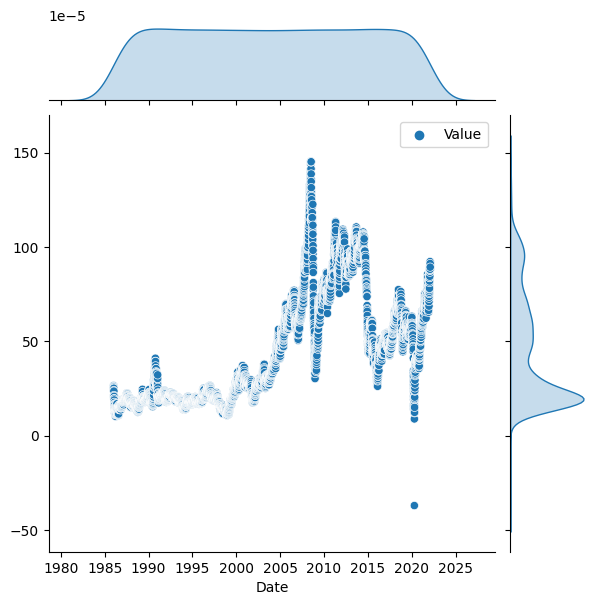

In [9]:
sns.jointplot(df)  # see data distribution

In [8]:
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [10]:
# If we see Date Index column, we don't have any fixed frequency(time interval between two records), in order to 
# perform time series operations its important to have a fixed period/ frequency of the date series, by making our
# frequency fixed we can plot seasonal decompositon to check trend, seasonality and perform other statistical
# operations

In [11]:
# In order to fix the frequency, we will calculate mean of every month of the data and use it to perform time
# series

start_date = '1986-01-02'
end_date = '2022-02-08'

filtered_date = df.loc[start_date: end_date]

monthly_mean = filtered_date.resample('M').mean()

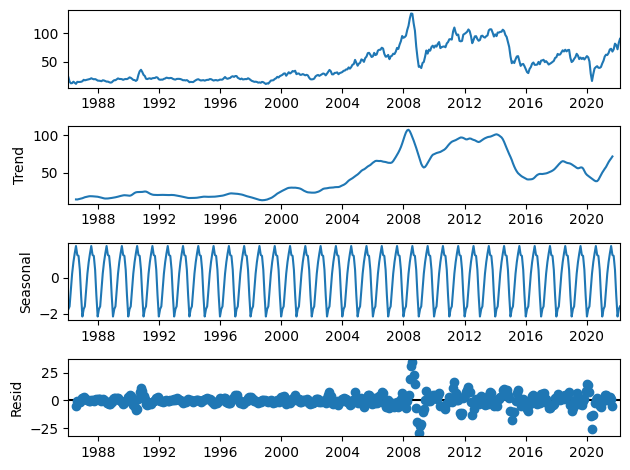

In [13]:
# check trend, seasonality
decomposition = sm.tsa.seasonal_decompose(monthly_mean, model='additive') 
fig = decomposition.plot()

In [14]:
# we can clearly see  presence of trend and seasonality in our dataset 

In [15]:
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [16]:
# check stationarity by doing Adfuller test
ADF_result = adfuller(monthly_mean)
ADF_result

(-2.2784764077398916,
 0.1790037438773498,
 1,
 432,
 {'1%': -3.445578199334947,
  '5%': -2.8682536932290876,
  '10%': -2.570346162765775},
 2387.154995100863)

In [17]:
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -2.2784764077398916
p-value: 0.1790037438773498


In [19]:
# since our data is not stationary as the p-value is more than 0.05, we'll order first order of differencing to 
# make the series stationary

diff_df = np.diff(monthly_mean['Value'], n= 1)

In [20]:
ADF_result = adfuller(diff_df)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -14.099649789796436
p-value: 2.632498317224211e-26


In [21]:
# since p-value is less than 0.05 and test statistics is also large negative, it is now stationary

In [22]:
# since there is seasonality in our data, we'll proceed with SARIMA(p,d,q)(P,D,Q)m model.

In [23]:
ps = range(0, 3, 1)
qs = range(0, 3, 1)
Ps = range(0, 3, 1)
Qs = range(0, 3, 1)

from itertools import product
SARIMA_order_list = list(product(ps, qs, Ps, Qs))

In [25]:
# this function returns a dataframe where we'll all sets of (p,d,q)(P,D,Q) and returns the best with lowest
# aic score, which gives us the best parameters for our SARIMA model on our data

from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMA(training_data, order_list, d, D, s):
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                training_data,
                order = (order[0], d, order[1]),
                seasonal_order = (order[2], D, order[3], s),
                simple_differencing= False).fit(disp = False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC',ascending=True).reset_index(drop=True)
    
    return result_df

In [26]:
train = monthly_mean['Value'][:-60]
d = 1
D = 1
s = 12

import warnings
warnings.filterwarnings("ignore")

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s) #fit all sarima models
SARIMA_result_df

  0%|          | 0/81 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 2, 2, 1)",2052.448765
1,"(2, 2, 2, 2)",2053.171329
2,"(2, 2, 1, 2)",2056.006863
3,"(1, 0, 2, 2)",2057.839342
4,"(0, 2, 2, 2)",2057.978250
...,...,...
76,"(2, 1, 0, 0)",2243.661709
77,"(0, 2, 0, 0)",2244.271737
78,"(0, 0, 1, 0)",2244.565104
79,"(0, 1, 0, 0)",2262.285834


In [27]:
# now we need to perform residual anlysis checks to be sure that the parameter yeilded by aic score is random,
# so we'll check by plotting QQ plot and then chech Ljung-box text

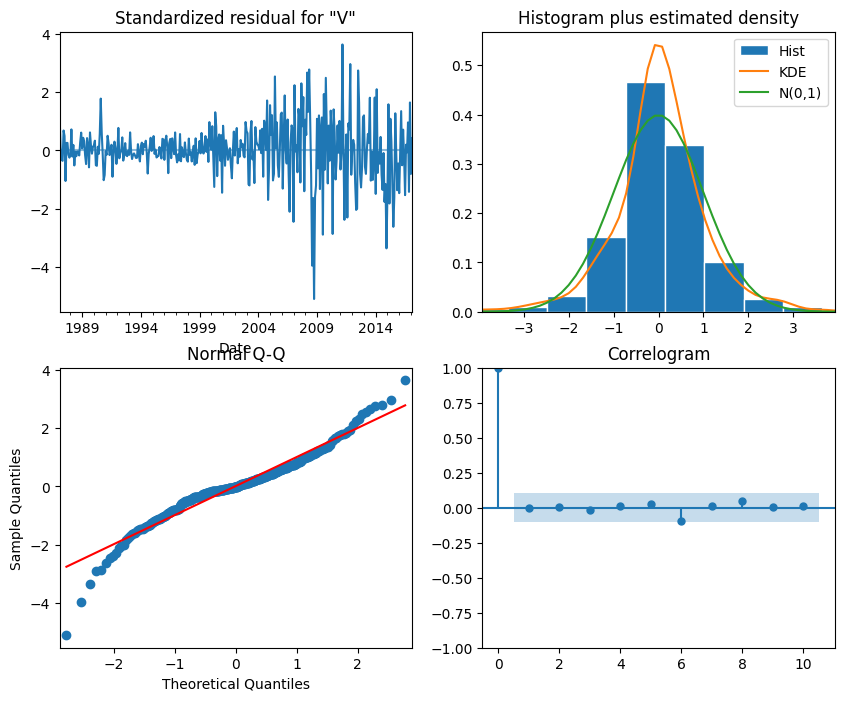

In [28]:
SARIMA_model = SARIMAX(train, order=(2,1,2), seasonal_order=(2,1,1,12),simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [29]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residuals = SARIMA_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1), return_df= True)

,lb_stat,lb_pvalue
1,0.583561,0.444920
2,0.643354,0.724932
3,0.726363,0.866986
4,1.075790,0.898094
5,1.078806,0.955962
6,4.542034,0.603739
7,5.009888,0.658757
8,5.457022,0.707797
9,5.457102,0.792782
10,5.647831,0.843933


In [30]:
# The returned p-values are all greater than 0.05. Therefore, we do not reject the null
# hypothesis, and we conclude that the residuals are independent and uncorrelated,
# just like white noise.

In [31]:
test = monthly_mean[-60:] # take 5 years of data in test set

In [32]:
SARIMA_pred = SARIMA_model_fit.get_prediction(374, 434).predicted_mean # get predictions of our test set 
test['SARIMA_pred'] = SARIMA_pred

In [33]:
test.head()

,Value,SARIMA_pred
Date,,
2017-03-31,49.327826,57.289417
2017-04-30,51.060526,58.124218
2017-05-31,48.476364,58.559759
2017-06-30,45.177727,59.141497
2017-07-31,46.600000,60.484559


In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(test['Value'], test['SARIMA_pred'])
mae = mean_absolute_error(test['Value'], test['SARIMA_pred'])

In [35]:
mse, mae

(186.8834470917454, 10.057893404124817)

In [36]:
# So, till here we have got our predictions from our SARIMA model, but we had to somehow get an intuition that 
# our model is good predictior of the series , So, we must find a baseline model to compare our Sarima model
# In this case, a baseline model could be just predicting the exact last 60 months of training set values for our 
# test set values, as it is recent values.

In [37]:
test['naive_seasonal'] = monthly_mean.iloc[314:374].values # last 60 values of training set

In [38]:
test.head()

,Value,SARIMA_pred,naive_seasonal
Date,,,
2017-03-31,49.327826,57.289417,106.157727
2017-04-30,51.060526,58.124218,103.321000
2017-05-31,48.476364,58.559759,94.654545
2017-06-30,45.177727,59.141497,82.303333
2017-07-31,46.600000,60.484559,87.895238


In [39]:
mse_naive = mean_squared_error(test['Value'], test['naive_seasonal'])
mae_naive = mean_absolute_error(test['Value'], test['naive_seasonal'])

In [40]:
mse_naive, mae_naive

(1059.617644306952, 29.5534199987232)

In [41]:
# We can clearly see that our loss metric is way less for SARIMA model than our baseline model, so we can conclude
# that SARIMA model is able to capture data behaviour in better manner.

In [42]:
# Finally let's build our own loss metric Mean Absolute Percentage Error and see a plot difference between both the
# models

In [43]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [44]:
mape_naive = mape(test['Value'], test['naive_seasonal'])
mape_SARIMA = mape(test['Value'], test['SARIMA_pred'])

In [45]:
mape_naive, mape_SARIMA

(55.29971425921395, 23.641998873432932)

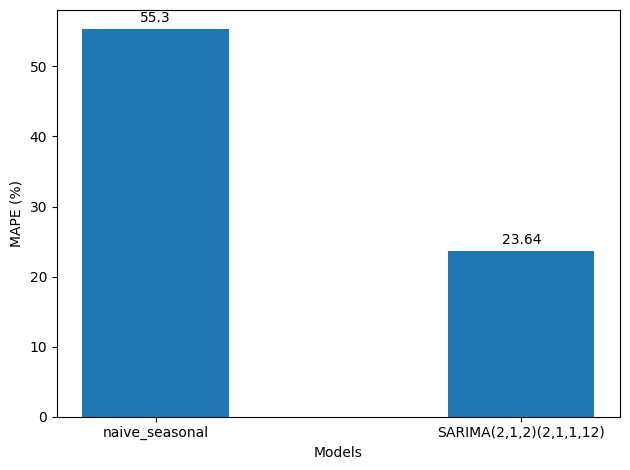

In [46]:
x = ['naive_seasonal', 'SARIMA(2,1,2)(2,1,1,12)']
y = [mape_naive, mape_SARIMA]

fig, ax = plt.subplots()
ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')

#Display the MAPE as text in the bar plot.
for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')
    plt.tight_layout()